# Similarity Measures for Fish Welfare Criteria
### Initial Hypotheses
Certain criteria will have a higher potential of being jointly met, be that because farms that meet this criteria, automatically meet other criteria, or because criteria are inter-related somehow. For example, we might imagine stress and aggression to be more related as we expect stress to exacerbate aggression, and we might expect home range and aggression to be related as fish in confined spaces may become more aggressive.

* [_An ordinal attribute is an attribute whose possible values have a meaningful order or ranking among them, but the magnitude between successive values is not known._](https://www.raynergobran.com/2016/02/distance-observations-numeric-ordinal/)
* [Distance for ordinal measures](https://people.revoledu.com/kardi/tutorial/Similarity/OrdinalVariables.html)

### Criteria (add explanations)
Home range: <br>
Depth range: <br>
Migration: <br>
Reproduction: <br>
Aggregation: <br>
Aggression: <br>
Substrate: <br>
Stress: <br>
Malformation: <br>
Slaughter: <br>

In [21]:
from os.path import exists, join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def make_multilevel(likelihood, potential):
    likelihood_t = likelihood.transpose()
    likelihood_t['level'] = ['likelihood'] * 10

    potential_t = potential.transpose()
    potential_t['level'] = ['potential'] * 10
    
    both = pd.concat([likelihood_t, potential_t])
    both = both.groupby(['Criterion', 'level']).agg(lambda x: x)
    both = both.transpose()
    
    return both

In [22]:
df = pd.read_csv(join('..', 'data', 'feb_farm_data_s2.csv'))

# get criterion dictionary
criteria_df = df.head(10)[['Criterion.1', 'Unnamed: 7']].set_index('Criterion.1')
criteria_df.index.name = 'index'
criteria_df.columns = ['criterion']
criteria_dict = {int(val): name for val, name in zip(criteria_df.index, criteria_df['criterion'])}

# set up dataframe for each of likelihood, potential, and uncertainty
likelihood = df.pivot(index="Fish ID", columns="Criterion", values="Likelihood")
potential = df.pivot(index="Fish ID", columns="Criterion", values="Potential")
certainty = df.pivot(index="Fish ID", columns="Criterion", values="Certainty")

# combine into one multiindex df
df_all = make_multilevel(likelihood, potential)

criteria_dict

{17: 'Home range',
 18: 'Depth range',
 29: 'Migration',
 30: 'Reproduction',
 31: 'Aggregation',
 32: 'Aggression',
 33: 'Substrate',
 34: 'Stress',
 35: 'Malformation',
 36: 'Slaughter'}

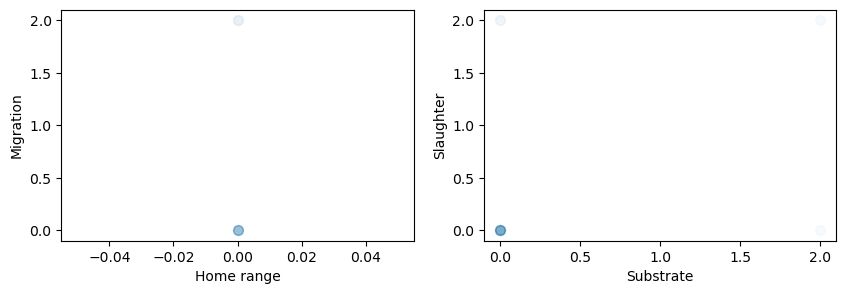

In [82]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

ax[0].scatter(likelihood[17], likelihood[29], alpha=0.03, s=50)
ax[0].set_xlabel(criteria_dict[17]);
ax[0].set_ylabel(criteria_dict[29]);

ax[1].scatter(likelihood[33], likelihood[36], alpha=0.03, s=50)
ax[1].set_xlabel(criteria_dict[33]);
ax[1].set_ylabel(criteria_dict[36]);

In [24]:
print('Check unique values (<0 should be removed)')
print(set(likelihood.values.ravel()))
print(set(potential.values.ravel()))

Check unique values (<0 should be removed)
{0, 2, -1, -2}
{0, 1, 2, -2, -1}


In [25]:
# make a multilevel dataframe and remove negative values
idx = pd.IndexSlice
both = make_multilevel(likelihood, potential)
both = both.applymap(lambda x: np.nan if x < 0 else x)
likelihood = both.loc[:, idx[:, 'likelihood']].droplevel('level', axis=1)
potential = both.loc[:, idx[:, 'potential']].droplevel('level', axis=1)

# get normalised rank transformations (to use with quantitative distance measures such as Euclidean)
likelihood_z = (likelihood) / (2 - 1)
potential_z = (potential) / (3 - 1)

# Measures in one dimension
## Euclidean Distance

$$ d(\mathbf{u}, \mathbf{v}) = \sqrt{\sum_{i=1}^n \left(u_i - v_i \right)^2} $$

In [26]:
def euclidean_dist(df, col1, col2):
    """Requires normalised data."""
    return np.sqrt(((df[col1] - df[col2])**2).sum())

print(f"Migration and home range likelihood: {euclidean_dist(likelihood_z, 17, 29):.4f}")
print(f"Substrate and slaughter likelihood: {euclidean_dist(likelihood_z, 33, 36):.4f}")

print(f"\nMigration and home range potential: {euclidean_dist(potential_z, 17, 29):.4f}")
print(f"Substrate and slaughter potential: {euclidean_dist(potential_z, 33, 36):.4f}")

Migration and home range likelihood: 3.4641
Substrate and slaughter likelihood: 3.4641

Migration and home range potential: 2.5000
Substrate and slaughter potential: 2.4495


## Cosine Similarity

$$ S_c(\mathbf{u}, \mathbf{v}) = \cos(\theta) = \frac{\mathbf{u} \cdot \mathbf{v}}{||\mathbf{u}||||\mathbf{v}||} = \frac{\sum_i^n u_iv_i}{\sqrt{\sum_i^n u_i^2}\sqrt{\sum_i^n v_i^2}} $$

In [27]:
def cosine_similarity(df, col1, col2):
    """Requires normalised data"""
    return (df[col1] * df[col2]).sum() / ( np.sqrt((df[col1]**2).sum()) * np.sqrt((df[col2]**2).sum()))

In [28]:
print(f"Migration and home range likelihood: {cosine_similarity(likelihood, 17, 29):.4f}")
print(f"Substrate and slaughter likelihood: {cosine_similarity(likelihood, 33, 36):.4f}")

print(f"Migration and home range potential: {cosine_similarity(potential, 17, 29):.4f}")
print(f"Substrate and slaughter potential: {cosine_similarity(potential, 33, 36):.4f}")

Migration and home range likelihood: nan
Substrate and slaughter likelihood: 0.4082
Migration and home range potential: 0.5415
Substrate and slaughter potential: 0.7752


/var/folders/7w/k72v6f5x25gblsqmh6bxd3j40000gn/T/ipykernel_55366/1276262231.py:3: RuntimeWarning: invalid value encountered in double_scalars
  return (df[col1] * df[col2]).sum() / ( np.sqrt((df[col1]**2).sum()) * np.sqrt((df[col2]**2).sum()))


## Plots

In [29]:
# Plot Cosine Similarities
def cosine_similarity(col1, col2):
    return (col1 * col2).sum() / ( np.sqrt((col1**2).sum()) * np.sqrt((col2**2).sum()))

def euclidean_similarity(col1, col2):
    """Requires normalised data."""
    euclidean_dist = np.sqrt(((col1 - col2)**2).sum())
    return 1 / (1 + euclidean_dist) - 1

/var/folders/7w/k72v6f5x25gblsqmh6bxd3j40000gn/T/ipykernel_55366/2382689039.py:3: RuntimeWarning: invalid value encountered in double_scalars
  return (col1 * col2).sum() / ( np.sqrt((col1**2).sum()) * np.sqrt((col2**2).sum()))


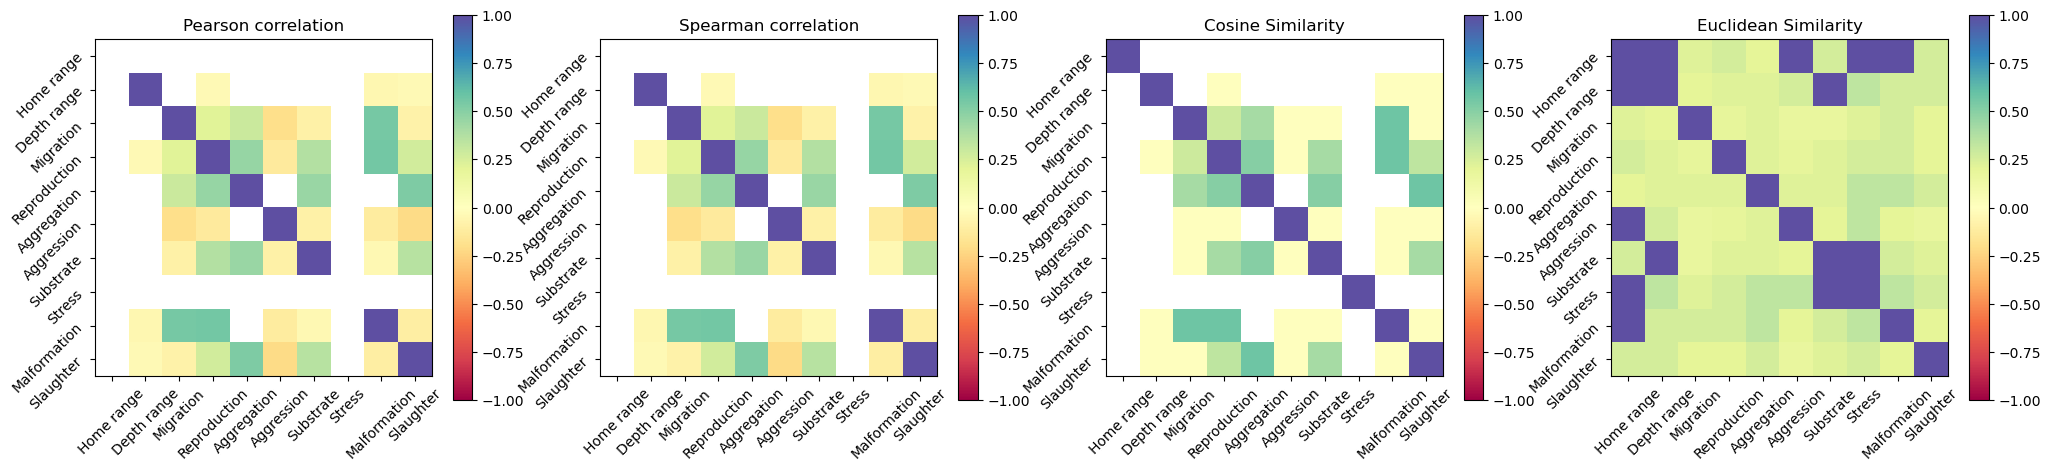

In [55]:
# plot correlation coefficients
pearson_likelihood = likelihood.corr(method='pearson')
spearman_likelihood = likelihood.corr(method='spearman')
cosine_likelihood = likelihood.corr(method=cosine_similarity)
euclidean_likelihood = likelihood_z.corr(method=euclidean_similarity)

fig, axs = plt.subplots(1, 4, figsize=(25, 5))

ax = axs[0]
im = ax.imshow(pearson_likelihood.to_numpy(), cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('Pearson correlation')
ax.set_xticks([*range(10)])
ax.set_yticks([*range(10)])
ax.set_xticklabels([*criteria_dict.values()], rotation=45)
ax.set_yticklabels([*criteria_dict.values()], rotation=45)
plt.colorbar(im, ax=ax);

ax = axs[1]
im = ax.imshow(spearman_likelihood.to_numpy(), cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('Spearman correlation')
ax.set_xticks([*range(10)])
ax.set_yticks([*range(10)])
ax.set_xticklabels([*criteria_dict.values()], rotation=45)
ax.set_yticklabels([*criteria_dict.values()], rotation=45)
plt.colorbar(im, ax=ax);

ax = axs[2]
im = ax.imshow(cosine_likelihood.to_numpy(), cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('Cosine Similarity')
ax.set_xticks([*range(10)])
ax.set_yticks([*range(10)])
ax.set_xticklabels([*criteria_dict.values()], rotation=45)
ax.set_yticklabels([*criteria_dict.values()], rotation=45)
plt.colorbar(im, ax=ax);

ax = axs[3]
im = ax.imshow(euclidean_likelihood.to_numpy(), cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('Euclidean Similarity')
ax.set_xticks([*range(10)])
ax.set_yticks([*range(10)])
ax.set_xticklabels([*criteria_dict.values()], rotation=45)
ax.set_yticklabels([*criteria_dict.values()], rotation=45)
plt.colorbar(im, ax=ax);

fig.savefig(join('..', 'images', 'likelihood.png'))

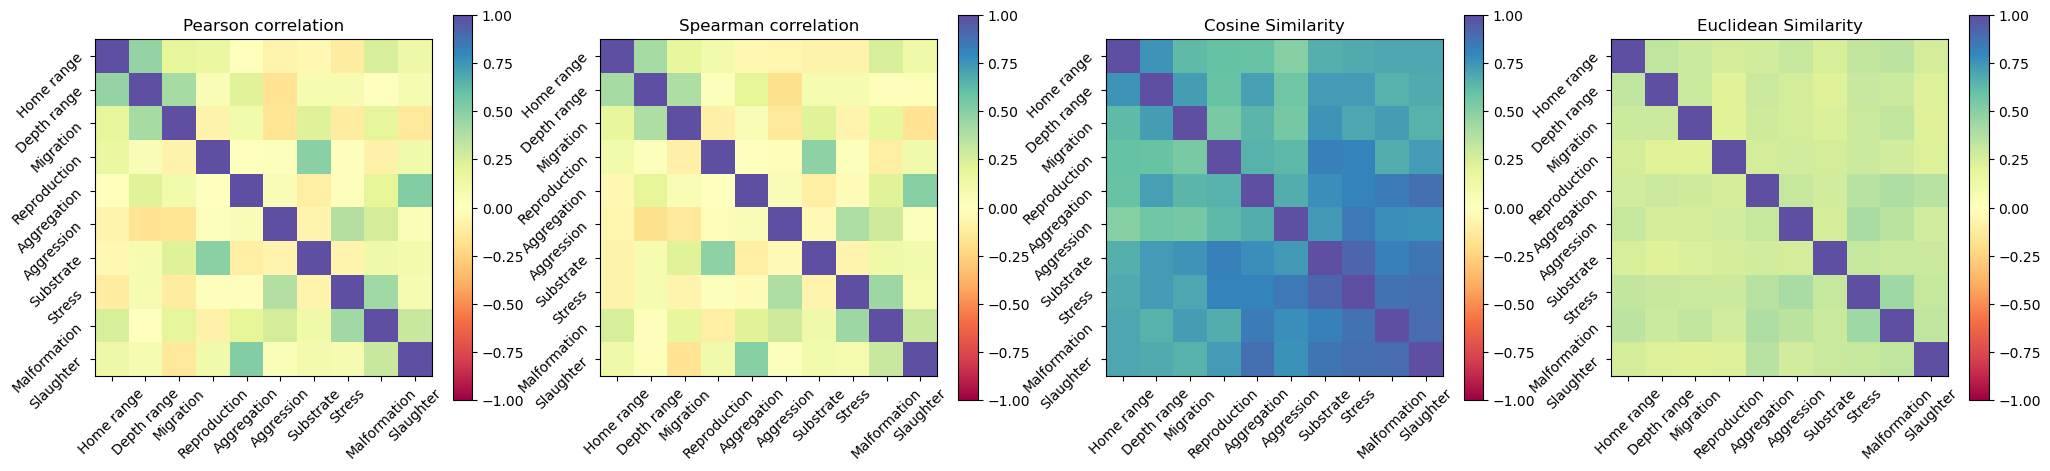

In [57]:
# plot correlation coefficients for potential
pearson_potential = potential.corr(method='pearson')
spearman_potential = potential.corr(method='spearman')
cosine_potential = potential.corr(method=cosine_similarity)
euclidean_potential = potential_z.corr(method=euclidean_similarity)

fig, axs = plt.subplots(1, 4, figsize=(25, 5))

ax = axs[0]
im = ax.imshow(pearson_potential.to_numpy(), cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('Pearson correlation')
ax.set_xticks([*range(10)])
ax.set_yticks([*range(10)])
ax.set_xticklabels([*criteria_dict.values()], rotation=45)
ax.set_yticklabels([*criteria_dict.values()], rotation=45)
plt.colorbar(im, ax=ax);

ax = axs[1]
im = ax.imshow(spearman_potential.to_numpy(), cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('Spearman correlation')
ax.set_xticks([*range(10)])
ax.set_yticks([*range(10)])
ax.set_xticklabels([*criteria_dict.values()], rotation=45)
ax.set_yticklabels([*criteria_dict.values()], rotation=45)
plt.colorbar(im, ax=ax);

ax = axs[2]
im = ax.imshow(cosine_potential.to_numpy(), cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('Cosine Similarity')
ax.set_xticks([*range(10)])
ax.set_yticks([*range(10)])
ax.set_xticklabels([*criteria_dict.values()], rotation=45)
ax.set_yticklabels([*criteria_dict.values()], rotation=45)
plt.colorbar(im, ax=ax);

ax = axs[3]
im = ax.imshow(euclidean_potential.to_numpy(), cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('Euclidean Similarity')
ax.set_xticks([*range(10)])
ax.set_yticks([*range(10)])
ax.set_xticklabels([*criteria_dict.values()], rotation=45)
ax.set_yticklabels([*criteria_dict.values()], rotation=45)
plt.colorbar(im, ax=ax);

fig.savefig(join('..', 'images', 'potential.png'))

# Similarities between fishes
Later...

# Sampling data 
**Certainty values:** -2 (no findings), 0 (low), 1 (medium), 2 (high). <br>
**Idea:** Re-sample data according to certainty values.
$$ \mathbb{P}_{\text{high}}(a, b, c | a) = (0.99, 0.05, 0.05) $$
$$ \mathbb{P}_{\text{medium}}(a, b, c | a) = (0.90, 0.5, 0.5) $$
$$ \mathbb{P}_{\text{low}}(a, b, c | a) = (0.5, 0.25, 0.25) $$

In [32]:
certainty_probs = {0: (0.005, 0.99), 
                   1: (0.05, 0.9),
                   2: (0.25, 0.5)}

def probabilities(score, possible_scores, certainty):
    high = certainty_probs[certainty][1]
    low = certainty_probs[certainty][0]
    probabilities = [high if pscore==score else low for pscore in possible_scores]
    return probabilities

def random_sample(measure, certainty):
    pass

potential_sample = {}
likelihood_sample = {}

In [98]:
n = 5

for criterion in [*criteria_dict.keys()]:
    sample = np.array([])
    possible_scores = [0, 1, 2]  # potential
    scores = [(score, cert) for score, cert in zip(potential[criterion], certainty[criterion])]
    for score in scores:
        if not np.isnan(score[0]):
            probabilities(score[0], [0, 1, 2], score[1])
            sample = np.append(sample, np.random.choice(possible_scores, n, p=probabilities(score[0], [0, 1, 2], score[1])))
        else:
            sample = np.append(sample, [np.nan] * n)

    potential_sample[criterion] = sample

potential_sample_df = pd.DataFrame.from_dict(potential_sample)
potential_sample_df_z = (potential_sample_df) / (3 - 1)


for criterion in [*criteria_dict.keys()]:
    sample = np.array([])
    possible_scores = [0, 1, 2]  # potential
    scores = [(score, cert) for score, cert in zip(likelihood[criterion], certainty[criterion])]
    for score in scores:
        if not np.isnan(score[0]):
            probabilities(score[0], [0, 1, 2], score[1])
            sample = np.append(sample, np.random.choice(possible_scores, n, p=probabilities(score[0], [0, 1, 2], score[1])))
        else:
            sample = np.append(sample, [np.nan] * n)

    likelihood_sample[criterion] = sample
    
likelihood_sample_df = pd.DataFrame.from_dict(likelihood_sample)
likelihood_sample_df_z = (likelihood_sample_df) / (2 - 1)

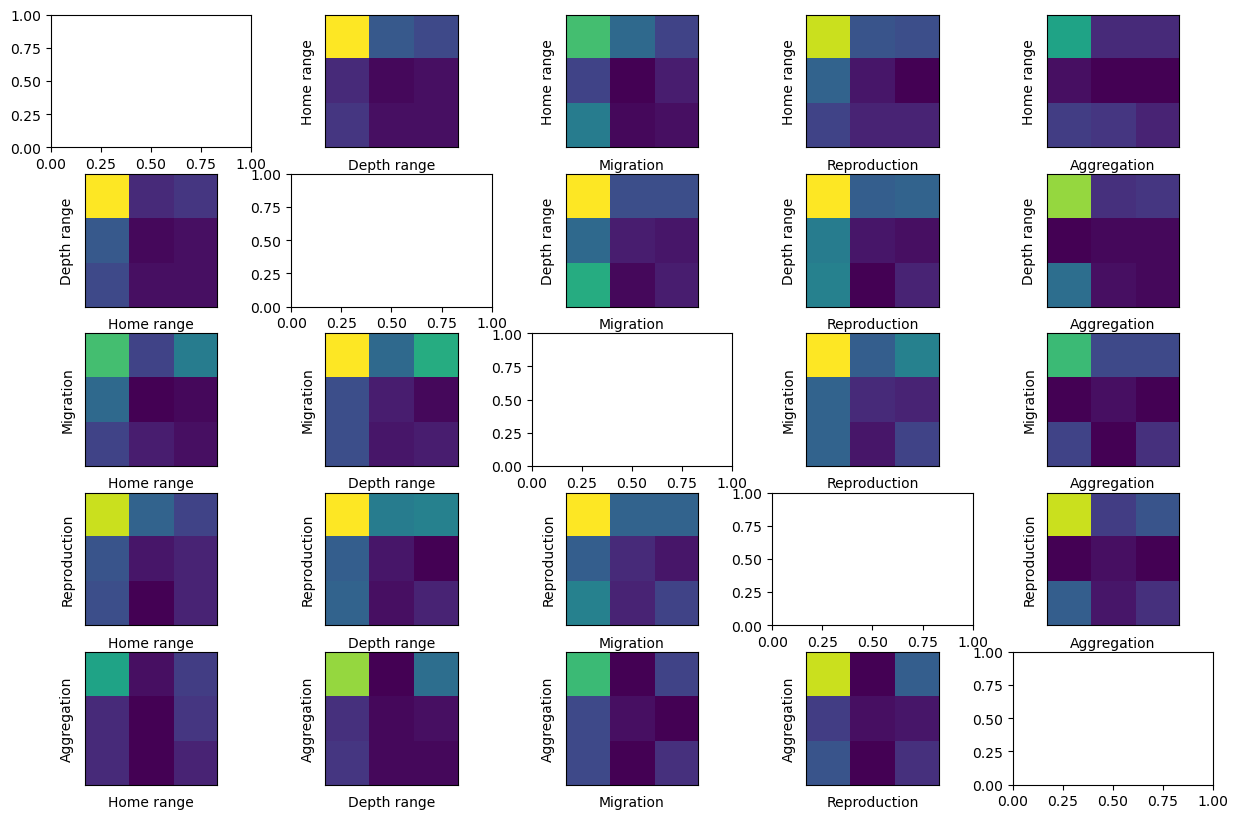

In [253]:
def make_heatmap(df, row1, row2, **kwargs):
    """Make a heatmap for value counts of each ranking."""
    
    value_counts = np.zeros((3, 3))
    
    for ix, row in df[[row1, row2]].iterrows():
        if (not np.isnan(row[row1])) and (not np.isnan(row[row2])):

            value_counts[int(row[row1]), int(row[row2])] += 1
        
    return value_counts

fig, axs = plt.subplots(5, 5, figsize=(15, 10))

for i in range(5):
    for j in range(5):
        if j != i:
            ax = axs[j, i]
            ix = [*criteria_dict.keys()][i]
            jx = [*criteria_dict.keys()][j]
            #print(f"{(ix, jx)}:")

            xlabel = [*criteria_dict.values()][i]
            ylabel = [*criteria_dict.values()][j]

            value_counts = make_heatmap(likelihood_sample_df, ix, jx)
            #print(f"min: {value_counts.min()}, max: {value_counts.max()}")
            ax.imshow(value_counts, vmin=0, vmax=50)

            # make_heatmap(likelihood_sample_df, ix, jx, ax=ax, vmin=2000, vmax=2500)
            #ax.scatter(likelihood_sample_df[ix], likelihood_sample_df[jx], alpha=0.03, s=100)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_xticklabels([])
            ax.set_yticklabels([])

            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)
        

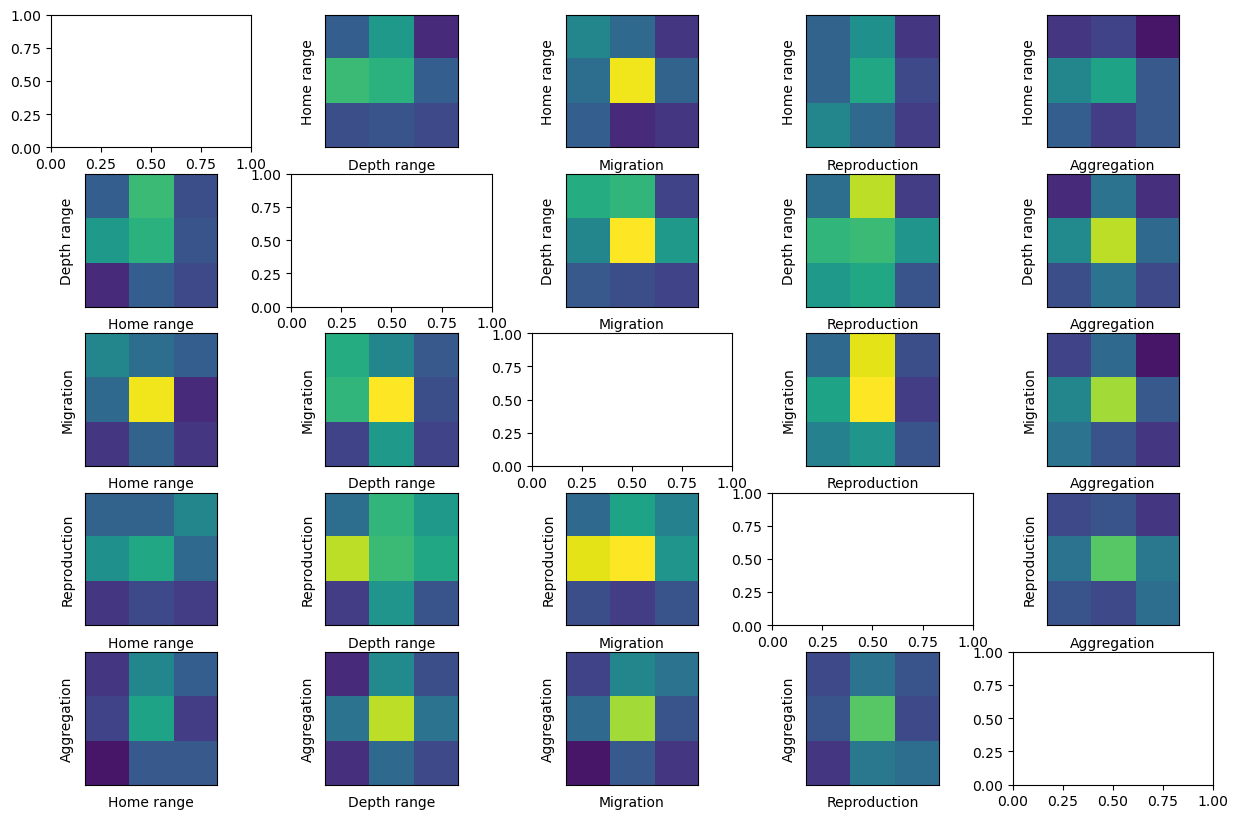

In [258]:
fig, axs = plt.subplots(5, 5, figsize=(15, 10))

for i in range(5):
    for j in range(5):
        if j != i:
            ax = axs[j, i]
            ix = [*criteria_dict.keys()][i]
            jx = [*criteria_dict.keys()][j]
            #print(f"{(ix, jx)}:")

            xlabel = [*criteria_dict.values()][i]
            ylabel = [*criteria_dict.values()][j]

            value_counts = make_heatmap(potential_sample_df, ix, jx)
            #print(f"min: {value_counts.min()}, max: {value_counts.max()}")
            ax.imshow(value_counts, vmin=0, vmax=50)

            #ax.scatter(potential_sample_df[ix], potential_sample_df[jx], alpha=0.03, s=100)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_xticklabels([])
            ax.set_yticklabels([])

            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)

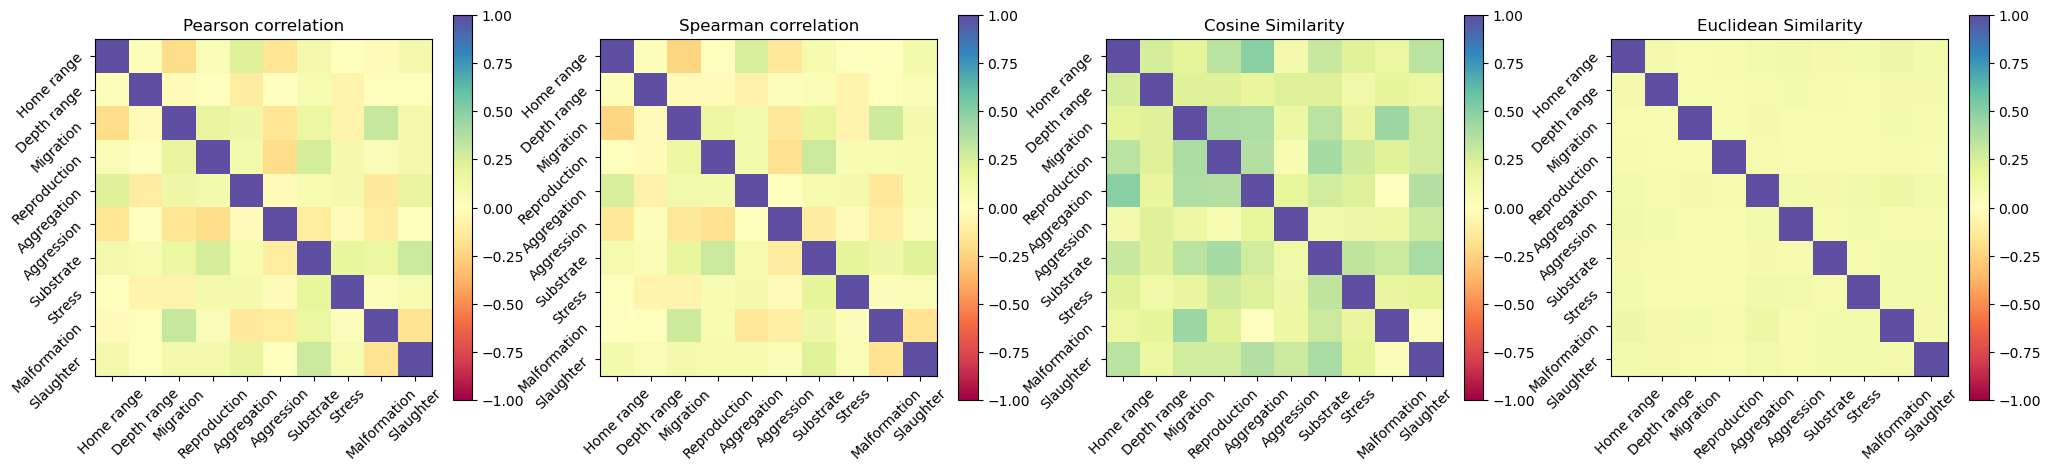

In [100]:
# plot correlation coefficients for likelihood
pearson_likelihood = likelihood_sample_df.corr(method='pearson')
spearman_likelihood = likelihood_sample_df.corr(method='spearman')
cosine_likelihood = likelihood_sample_df.corr(method=cosine_similarity)
euclidean_likelihood = likelihood_sample_df_z.corr(method=euclidean_similarity)

fig, axs = plt.subplots(1, 4, figsize=(25, 5))

ax = axs[0]
im = ax.imshow(pearson_likelihood.to_numpy(), cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('Pearson correlation')
ax.set_xticks([*range(10)])
ax.set_yticks([*range(10)])
ax.set_xticklabels([*criteria_dict.values()], rotation=45)
ax.set_yticklabels([*criteria_dict.values()], rotation=45)
plt.colorbar(im, ax=ax);

ax = axs[1]
im = ax.imshow(spearman_likelihood.to_numpy(), cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('Spearman correlation')
ax.set_xticks([*range(10)])
ax.set_yticks([*range(10)])
ax.set_xticklabels([*criteria_dict.values()], rotation=45)
ax.set_yticklabels([*criteria_dict.values()], rotation=45)
plt.colorbar(im, ax=ax);

ax = axs[2]
im = ax.imshow(cosine_likelihood.to_numpy(), cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('Cosine Similarity')
ax.set_xticks([*range(10)])
ax.set_yticks([*range(10)])
ax.set_xticklabels([*criteria_dict.values()], rotation=45)
ax.set_yticklabels([*criteria_dict.values()], rotation=45)
plt.colorbar(im, ax=ax);

ax = axs[3]
im = ax.imshow(euclidean_likelihood.to_numpy(), cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('Euclidean Similarity')
ax.set_xticks([*range(10)])
ax.set_yticks([*range(10)])
ax.set_xticklabels([*criteria_dict.values()], rotation=45)
ax.set_yticklabels([*criteria_dict.values()], rotation=45)
plt.colorbar(im, ax=ax);


fig.savefig(join('..', 'images', 'likelihood_resample.png'))

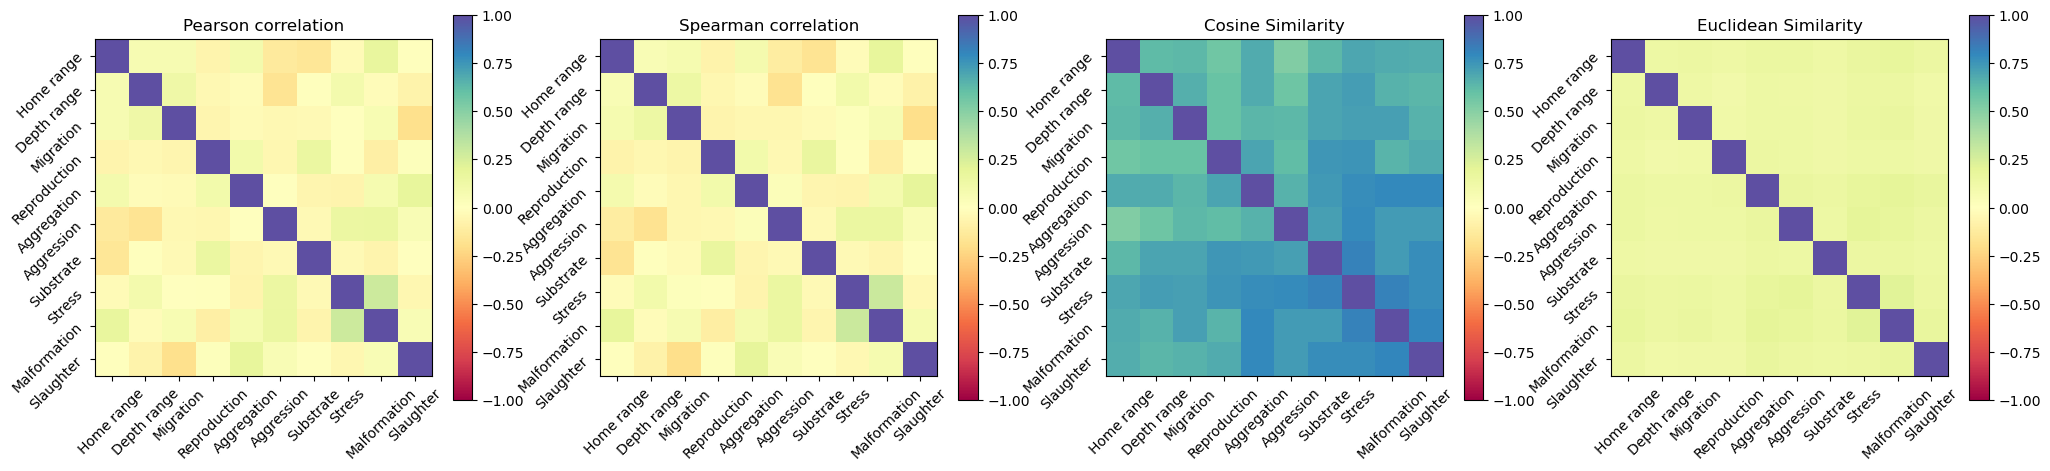

In [101]:
# plot correlation coefficients for potential
pearson_potential = potential_sample_df.corr(method='pearson')
spearman_potential = potential_sample_df.corr(method='spearman')
cosine_potential = potential_sample_df.corr(method=cosine_similarity)
euclidean_potential = potential_sample_df_z.corr(method=euclidean_similarity)

fig, axs = plt.subplots(1, 4, figsize=(25, 5))

ax = axs[0]
im = ax.imshow(pearson_potential.to_numpy(), cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('Pearson correlation')
ax.set_xticks([*range(10)])
ax.set_yticks([*range(10)])
ax.set_xticklabels([*criteria_dict.values()], rotation=45)
ax.set_yticklabels([*criteria_dict.values()], rotation=45)
plt.colorbar(im, ax=ax);

ax = axs[1]
im = ax.imshow(spearman_potential.to_numpy(), cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('Spearman correlation')
ax.set_xticks([*range(10)])
ax.set_yticks([*range(10)])
ax.set_xticklabels([*criteria_dict.values()], rotation=45)
ax.set_yticklabels([*criteria_dict.values()], rotation=45)
plt.colorbar(im, ax=ax);

ax = axs[2]
im = ax.imshow(cosine_potential.to_numpy(), cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('Cosine Similarity')
ax.set_xticks([*range(10)])
ax.set_yticks([*range(10)])
ax.set_xticklabels([*criteria_dict.values()], rotation=45)
ax.set_yticklabels([*criteria_dict.values()], rotation=45)
plt.colorbar(im, ax=ax);

ax = axs[3]
im = ax.imshow(euclidean_potential.to_numpy(), cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('Euclidean Similarity')
ax.set_xticks([*range(10)])
ax.set_yticks([*range(10)])
ax.set_xticklabels([*criteria_dict.values()], rotation=45)
ax.set_yticklabels([*criteria_dict.values()], rotation=45)
plt.colorbar(im, ax=ax);

fig.savefig(join('..', 'images', 'potential_resample.png'))

(array([ 8., 20., 18., 22.,  8., 14.,  0.,  0.,  0., 10.]),
 array([0.5621985 , 0.60597865, 0.6497588 , 0.69353895, 0.7373191 ,
        0.78109925, 0.8248794 , 0.86865955, 0.9124397 , 0.95621985,
        1.        ]),
 <BarContainer object of 10 artists>)

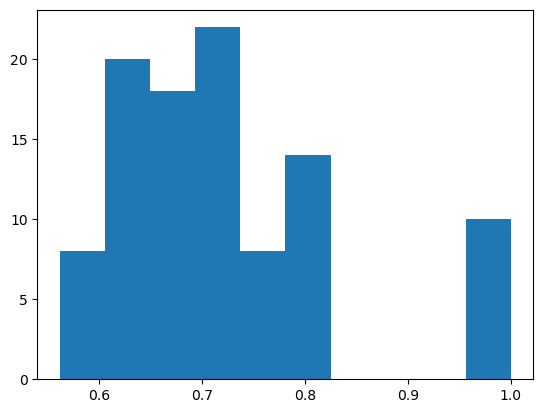

In [73]:
plt.hist(cosine_potential.to_numpy().ravel())

In [60]:
euclidean_potential

,17,18,29,30,31,32,33,34,35,36
17,1.000000,0.035211,0.033162,0.034325,0.038111,0.041933,0.032961,0.042294,0.044899,0.035133
18,0.035211,1.000000,0.030661,0.026891,0.036038,0.034850,0.028267,0.035762,0.036135,0.028833
29,0.033162,0.030661,1.000000,0.027397,0.035893,0.034267,0.030879,0.037398,0.040389,0.030178
30,0.034325,0.026891,0.027397,1.000000,0.034398,0.034563,0.027792,0.034552,0.034195,0.028647
31,0.038111,0.036038,0.035893,0.034398,1.000000,0.042443,0.035400,0.045917,0.052747,0.043948
32,0.041933,0.034850,0.034267,0.034563,0.042443,1.000000,0.033585,0.050637,0.043859,0.037063
33,0.032961,0.028267,0.030879,0.027792,0.035400,0.033585,1.000000,0.036007,0.037701,0.033590
34,0.042294,0.035762,0.037398,0.034552,0.045917,0.050637,0.036007,1.000000,0.051842,0.037778
35,0.044899,0.036135,0.040389,0.034195,0.052747,0.043859,0.037701,0.051842,1.000000,0.043532
36,0.035133,0.028833,0.030178,0.028647,0.043948,0.037063,0.033590,0.037778,0.043532,1.000000
